In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Hyperparameters
latent_dim = 128
input_shape = (256, 256, 1)
reg_factor = 0.01

# Encoder
encoder_inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, 2, strides=2, padding="same", kernel_regularizer=regularizers.l2(reg_factor))(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, 2, strides=2, padding="same", kernel_regularizer=regularizers.l2(reg_factor))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 2, strides=2, padding="same", kernel_regularizer=regularizers.l2(reg_factor))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, kernel_regularizer=regularizers.l2(reg_factor))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
z_mean = layers.Dense(latent_dim, kernel_regularizer=regularizers.l2(reg_factor))(x)
z_log_var = layers.Dense(latent_dim, kernel_regularizer=regularizers.l2(reg_factor))(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(z_log_var / 2) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 128, kernel_regularizer=regularizers.l2(reg_factor))(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Reshape((32, 32, 128))(x)
x = layers.Conv2DTranspose(64, 2, strides=2, padding="same", kernel_regularizer=regularizers.l2(reg_factor))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2DTranspose(32, 2, strides=2, padding="same", kernel_regularizer=regularizers.l2(reg_factor))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2DTranspose(32, 2, strides=2, padding="same", kernel_regularizer=regularizers.l2(reg_factor))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 2, activation="sigmoid", padding="same", kernel_regularizer=regularizers.l2(reg_factor))(x)

# VAE model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, vae_outputs, name="vae")

reconstruction_loss = tf.keras.losses.binary_crossentropy(encoder_inputs, vae_outputs)
reconstruction_loss = tf.reduce_mean(reconstruction_loss, axis=(1, 2))  # Calculate the mean over the image dimensions
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.7))

In [3]:
train = np.load('drive/MyDrive/Ferguson_fire_train.npy')
test = np.load('drive/MyDrive/Ferguson_fire_test.npy')

In [4]:
def reshape_data(data, sequence_length=10, group_size=100):
    inputs = []
    targets = []

    for i in range(0, len(data), group_size):

        for j in range(i, i + group_size - sequence_length):
            inputs.append(data[j])
            targets.append(data[j + sequence_length])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [5]:
x_train, y_train = reshape_data(train)
x_test, y_test = reshape_data(test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(11250, 256, 256)
(11250, 256, 256)
(4500, 256, 256)
(4500, 256, 256)


In [6]:
# Train the VAE model to predict the  t+10

# Define callbacks
# Stop training if the val_loss has not improved for 10 epochs
# Reduce the learning rate if the val_loss has not improved for 5 epochs
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
]

history = vae.fit(x_train, y_train, epochs=30, batch_size=45, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/30
250/250 [==============================] - 23s 50ms/step - loss: 24774.7637 - val_loss: 27507.8047 - lr: 1.0000e-04
Epoch 2/30
250/250 [==============================] - 11s 42ms/step - loss: 8991.1826 - val_loss: 8126.6206 - lr: 1.0000e-04
Epoch 3/30
250/250 [==============================] - 11s 42ms/step - loss: 5325.4551 - val_loss: 4300.4946 - lr: 1.0000e-04
Epoch 4/30
250/250 [==============================] - 11s 42ms/step - loss: 3825.2410 - val_loss: 3215.0247 - lr: 1.0000e-04
Epoch 5/30
250/250 [==============================] - 11s 42ms/step - loss: 3040.5837 - val_loss: 2641.5869 - lr: 1.0000e-04
Epoch 6/30
250/250 [==============================] - 11s 42ms/step - loss: 2551.2900 - val_loss: 2317.5393 - lr: 1.0000e-04
Epoch 7/30
250/250 [==============================] - 11s 42ms/step - loss: 2224.6948 - val_loss: 2044.8984 - lr: 1.0000e-04
Epoch 8/30
250/250 [==============================] - 11s 42ms/step - loss: 2001.5267 - val_loss: 1900.3499 - lr: 1.0000e-0

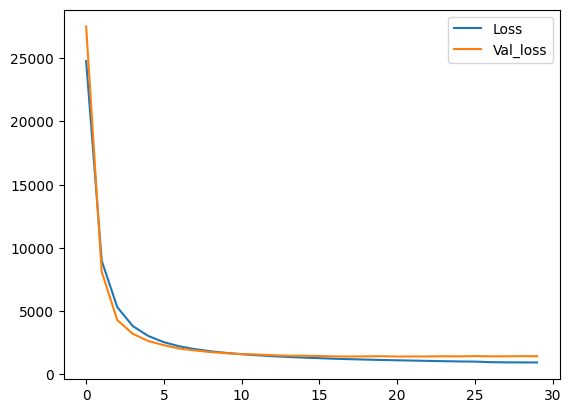

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss'])

In [8]:
def plot(data, indexes):
    fig, axs = plt.subplots(1, len(indexes), figsize=(20, 2))

    # loop over the images and plot each one
    for i, ax in enumerate(axs):
        ax.imshow(data[indexes[i]])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

157/157 [==============================] - 2s 7ms/step


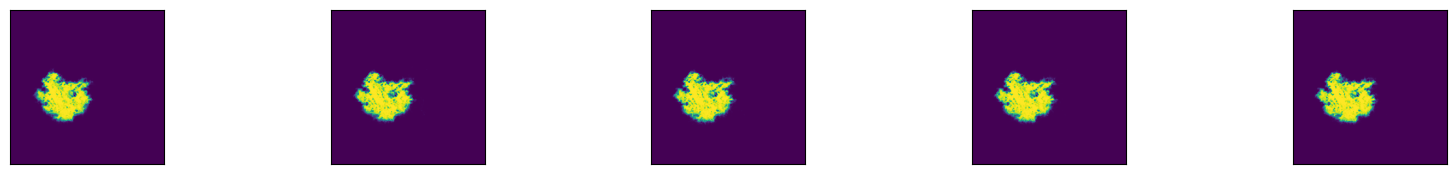

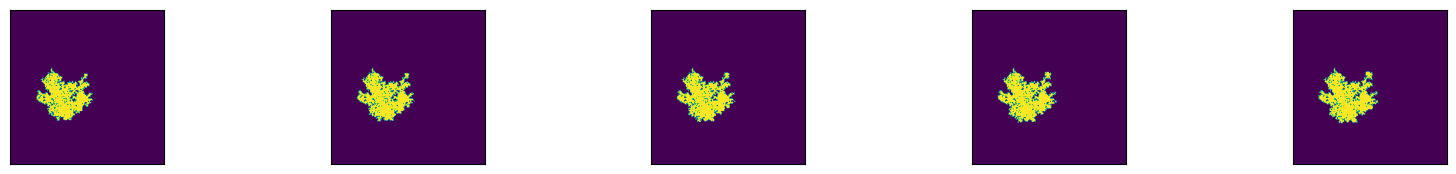

In [9]:
pred = vae.predict(test)

plot(pred, [2070, 2071, 2072, 2073, 2074])
plot(test, [2070, 2071, 2072, 2073, 2074])

In [10]:
model = np.load('drive/MyDrive/Ferguson_fire_background.npy')
satellite = np.load('drive/MyDrive/Ferguson_fire_obs.npy')

1/1 [==============================] - 0s 196ms/step


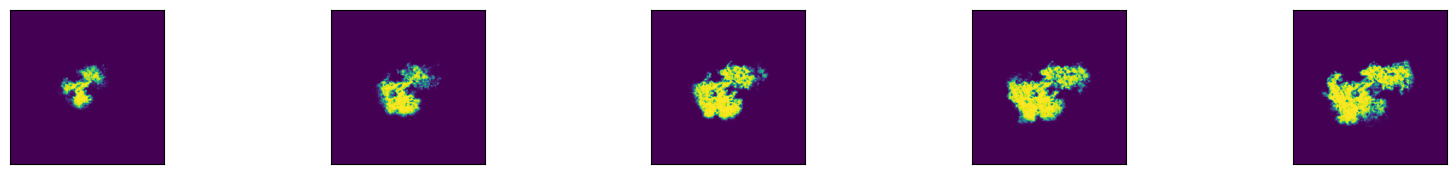

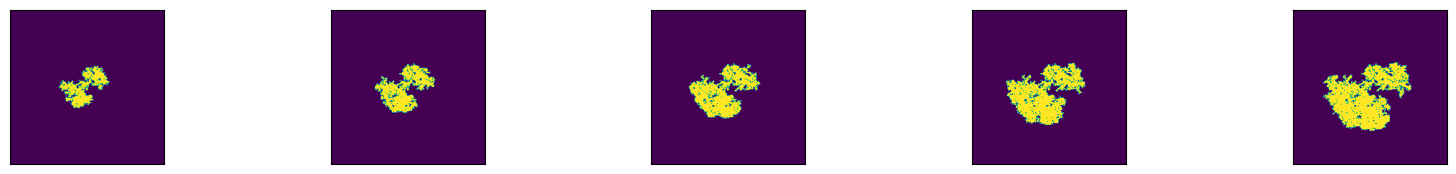

In [11]:
pred_model = vae.predict(model)

plot(pred_model, [0, 1, 2, 3, 4])
plot(model, [0, 1, 2, 3, 4])

In [12]:
print(mean_squared_error(pred_model.reshape(-1, 256*256), satellite.reshape(-1, 256*256)))

0.06714952784641319


In [13]:
vae.save('drive/MyDrive/vae_model')